# acGAN

Odena, Augustus, Christopher Olah, and Jonathon Shlens. "Conditional image synthesis with auxiliary classifier gans." arXiv preprint arXiv:1610.09585 (2016).

![acgan](acGAN.png)

## Equations

$$
L_S = E\left[ \log P(real|X_{real}) \right] + E\left[ \log P(fake|X_{fake}) \right] \\
L_C = E\left[\log P(c|X_{real})\right] + E\left[ \log P(c|X_{fake})\right]
$$

$D$ maximize $L_S + L_C$, $G$ maximize $L_C - L_S$.

## Intuitions

* 그냥 InfoGAN 에서 encoder 가 random-generated c 를 reconstruct 하는 것이 아니라 target label c 를 reconstruct 함
* 즉 supervised InfoGAN 이라고도 볼 수 있음
* 위 식을 해석해보면:
    * $L_S$ 는 그냥 GAN_loss. $L_C$ 는 class_loss. 
    * 즉 기본적인 GAN + D/G 는 classification 까지 잘 해야 함 (D는 말 그대로 classification 을 잘 해야 하고, G 는 classification 이 잘 되도록 이미지를 생성해야 함)
* cGAN 의 일종이라고 볼 수 있음

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

slim = tf.contrib.slim

In [2]:
import sys
sys.path.insert(0, '../')
from utils import *

In [3]:
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def lrelu(x, leak=0.1, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [5]:
def generator(z, reuse=False):
    with tf.variable_scope("generator", reuse=reuse):
        with slim.arg_scope([slim.fully_connected, slim.conv2d_transpose], 
                            normalizer_fn=slim.batch_norm, normalizer_params=bn_params,
                            activation_fn=tf.nn.relu):
            net = z
            net = slim.fully_connected(net, 1024)
            net = slim.fully_connected(net, 7*7*128)
            net = tf.reshape(net, [-1, 7, 7, 128])
            net = slim.conv2d_transpose(net, 64, [4,4], stride=2)
            net = slim.conv2d_transpose(net, 1, [4,4], stride=2, activation_fn=tf.nn.sigmoid, normalizer_fn=None)
            expected_shape(net, [None, 28, 28, 1])
            
            return net

In [6]:
def discriminator(x, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        with slim.arg_scope([slim.fully_connected, slim.conv2d],
                            normalizer_fn=slim.batch_norm, normalizer_params=bn_params,
                            activation_fn=lrelu):
            net = tf.reshape(x, [-1, 28, 28, 1])
            net = slim.conv2d(net, 64, [4,4], stride=2, normalizer_fn=None)
            net = slim.conv2d(net, 128, [4,4], stride=2)
            net = slim.flatten(net)
            net = slim.fully_connected(net, 1024)
            # D
            d_logits = slim.fully_connected(net, 1, activation_fn=None, normalizer_fn=None)
            expected_shape(d_logits, [None, 1])
            # Q
            q_net = slim.fully_connected(net, 128)
            q_logits = slim.fully_connected(q_net, 10, activation_fn=None, normalizer_fn=None)
            expected_shape(q_logits, [None, 10])
            
            return d_logits, q_logits

In [7]:
# for tf.losses module: this module emits INFO level logs (but does not informative)
tf.logging.set_verbosity(tf.logging.ERROR)

In [15]:
# build nets
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
c = tf.placeholder(tf.float32, [None, 10])
training = tf.placeholder(tf.bool)
z = tf.placeholder(tf.float32, [None, 64])

# BN 다음 activ fn 이 linear (lrelu/relu) 이므로 사실 scale 은 false 여도 된다.
bn_params = {
    'is_training': training, # global placeholder training
    'scale': True, 
    'decay': 0.99
}

zc = tf.concat([z, c], axis=1)

G_sample = generator(zc)
D_real_logits, c_real_logits = discriminator(X)
D_fake_logits, c_fake_logits = discriminator(G_sample, reuse=True)

# L_S
D_loss_real = tf.losses.sigmoid_cross_entropy(tf.ones_like(D_real_logits), D_real_logits, scope='D_loss/real')
D_loss_fake = tf.losses.sigmoid_cross_entropy(tf.zeros_like(D_fake_logits), D_fake_logits, scope='D_loss/fake')
D_loss = D_loss_real + D_loss_fake

# L_S - heuristic non-saturated version
G_loss = tf.losses.sigmoid_cross_entropy(tf.ones_like(D_fake_logits), D_fake_logits, scope='G_loss')

# L_C
Q_loss_real = tf.losses.softmax_cross_entropy(c, c_real_logits, scope='Q_loss/real')
Q_loss_fake = tf.losses.softmax_cross_entropy(c, c_fake_logits, scope='Q_loss/fake')
Q_loss = Q_loss_real + Q_loss_fake

D_loss += Q_loss
G_loss += Q_loss_fake 
# G 는 Q_loss_real 과는 상관이 없음. 
# 그냥 Q_loss 를 넣어줘도 gradient = 0 이 나와서 (Q_loss_real 부분은) 상관은 없는데, 
# 그러면 인풋으로 X 도 넣어줘야하고... 비효율적이라 뺌.

D_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
G_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
with tf.control_dependencies(G_update_ops):
    G_train_op = tf.train.AdamOptimizer(learning_rate=0.005, beta1=0.5).minimize(G_loss, var_list=G_vars)
with tf.control_dependencies(D_update_ops):
    D_train_op = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5).minimize(D_loss, var_list=D_vars)

In [9]:
def sample_z(n):
#     return np.random.randn(n, 62) # standard normal dist
    return np.random.uniform(-1, 1, [n, 64]) # uniform

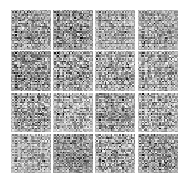

[1/30000] D_loss: 7.0803 | G_loss: 2.6544


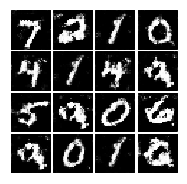

[1001/30000] D_loss: 1.3408 | G_loss: 0.8212


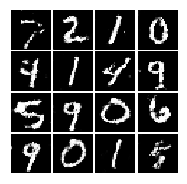

[2001/30000] D_loss: 1.4054 | G_loss: 0.7897


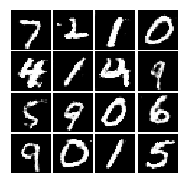

[3001/30000] D_loss: 1.4016 | G_loss: 0.7587


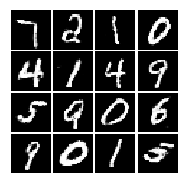

[4001/30000] D_loss: 1.3559 | G_loss: 0.7713


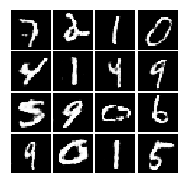

[5001/30000] D_loss: 1.3184 | G_loss: 0.7926


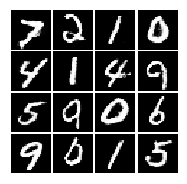

[6001/30000] D_loss: 1.3267 | G_loss: 0.8045


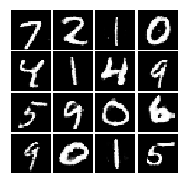

[7001/30000] D_loss: 1.3052 | G_loss: 0.8182


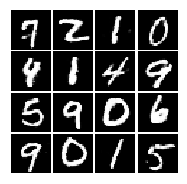

[8001/30000] D_loss: 1.2195 | G_loss: 0.8782


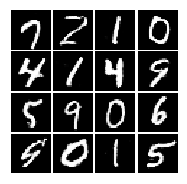

[9001/30000] D_loss: 1.1758 | G_loss: 0.9188


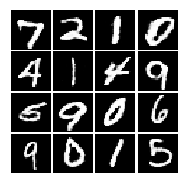

[10001/30000] D_loss: 1.1813 | G_loss: 0.9756


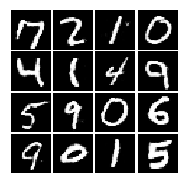

[11001/30000] D_loss: 1.1176 | G_loss: 1.0225


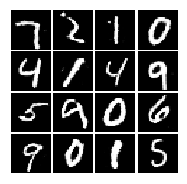

[12001/30000] D_loss: 1.0433 | G_loss: 1.1138


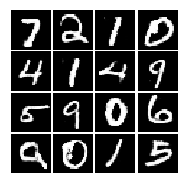

[13001/30000] D_loss: 0.9849 | G_loss: 1.1900


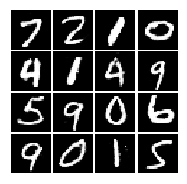

[14001/30000] D_loss: 0.9465 | G_loss: 1.2492


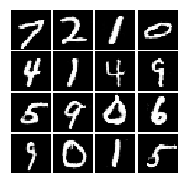

[15001/30000] D_loss: 0.8198 | G_loss: 1.3503


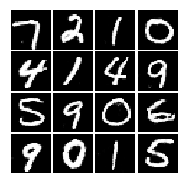

[16001/30000] D_loss: 0.8510 | G_loss: 1.5100


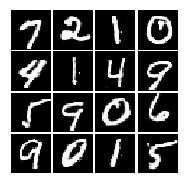

[17001/30000] D_loss: 0.7645 | G_loss: 1.5296


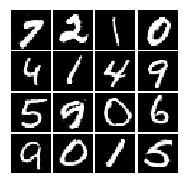

[18001/30000] D_loss: 0.7213 | G_loss: 1.6054


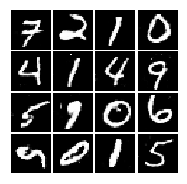

[19001/30000] D_loss: 0.7032 | G_loss: 1.7081


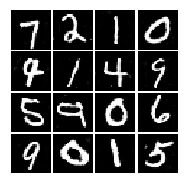

[20001/30000] D_loss: 0.7101 | G_loss: 1.7488


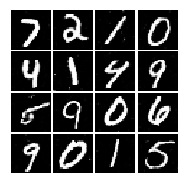

[21001/30000] D_loss: 0.6260 | G_loss: 1.9544


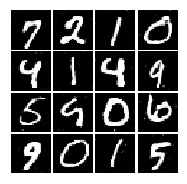

[22001/30000] D_loss: 0.5755 | G_loss: 1.9779


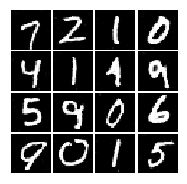

[23001/30000] D_loss: 0.5551 | G_loss: 1.9698


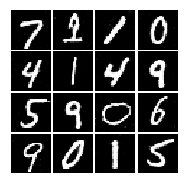

[24001/30000] D_loss: 0.4982 | G_loss: 2.1567


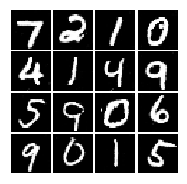

[25001/30000] D_loss: 0.5516 | G_loss: 2.3400


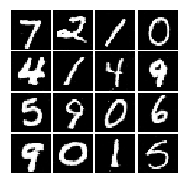

[26001/30000] D_loss: 0.5006 | G_loss: 2.4405


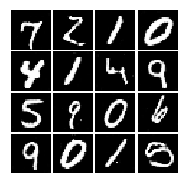

[27001/30000] D_loss: 0.4327 | G_loss: 2.2817


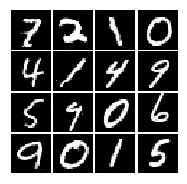

[28001/30000] D_loss: 0.4251 | G_loss: 2.5532


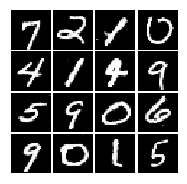

[29001/30000] D_loss: 0.4749 | G_loss: 2.3395


In [16]:
batch_size = 128
n_iter = 30000
print_step = 1000

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(n_iter):
    if i % print_step == 0:
        z_ = sample_z(16)
        c_ = mnist.test.labels[:16]
        samples = sess.run(G_sample, {z: z_, c: c_, training: False})
        fig = plot(samples)
        plt.show()
    
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    z_ = sample_z(batch_size)

    # double-step 이 자연스러움.. 
    _, D_loss_cur = sess.run([D_train_op, D_loss], {X: batch_x, z: z_, c: batch_y, training: True})
    _, G_loss_cur = sess.run([G_train_op, G_loss], {z: z_, c: batch_y, training: True})
#     _, _, D_loss_cur, G_loss_cur = sess.run([D_train_op, G_train_op, D_loss, G_loss], 
#                                             {X: batch_x, z: z_, c: c_, training: True})

    if i % print_step == 0:
        print('[{}/{}] D_loss: {:.4f} | G_loss: {:.4f}'.
              format(i+1, n_iter, D_loss_cur, G_loss_cur))

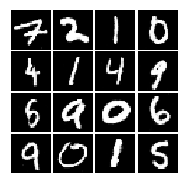

In [17]:
z_ = sample_z(16)
c_ = mnist.test.labels[:16]
samples = sess.run(G_sample, {z: z_, c: c_, training: False})
fig = plot(samples)
plt.show()

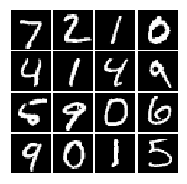

In [18]:
fig = plot(mnist.test.images[:16])
plt.show()

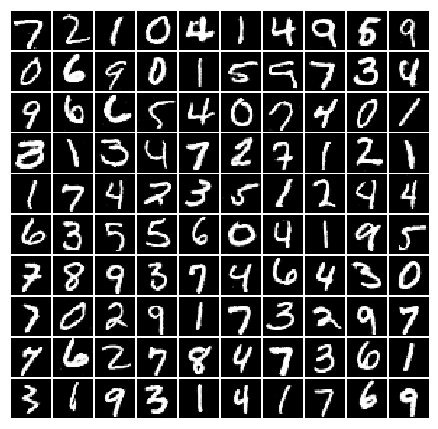

In [19]:
z_ = sample_z(100)
c_ = mnist.test.labels[:100]
samples = sess.run(G_sample, {z: z_, c: c_, training: False})
fig = plot(samples, shape=(10, 10))
plt.show()

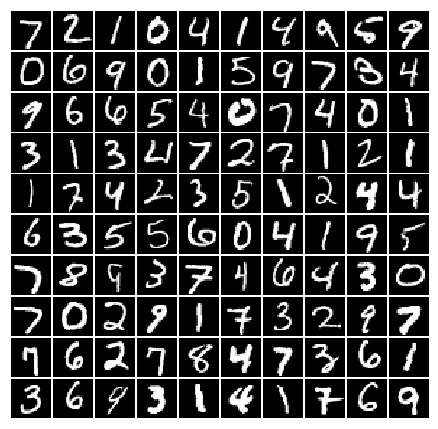

In [21]:
fig = plot(mnist.test.images[:100], shape=(10, 10))
plt.show()

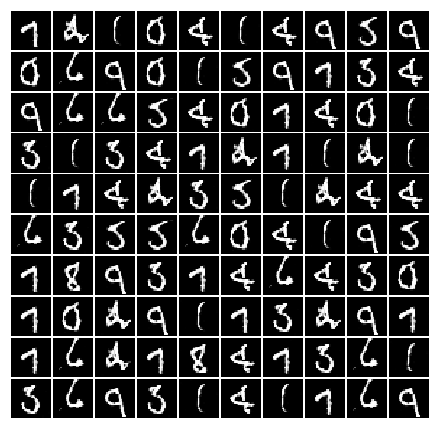

In [27]:
z_ = np.random.uniform(0.9, 1, [100, 64]) # uniform
c_ = mnist.test.labels[:100]
samples = sess.run(G_sample, {z: z_, c: c_, training: False})
fig = plot(samples, shape=(10, 10))
plt.show()

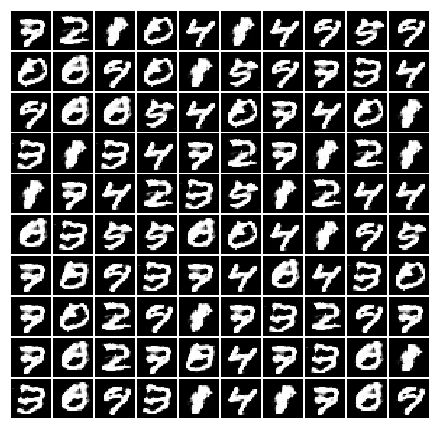

In [30]:
z_ = np.random.uniform(-1, -0.9, [100, 64]) # uniform
c_ = mnist.test.labels[:100]
samples = sess.run(G_sample, {z: z_, c: c_, training: False})
fig = plot(samples, shape=(10, 10))
plt.show()

In [47]:
v = np.tile(np.linspace(-1, 1, num=100), 64).reshape(64, 100).T

In [48]:
v.shape

(100, 64)

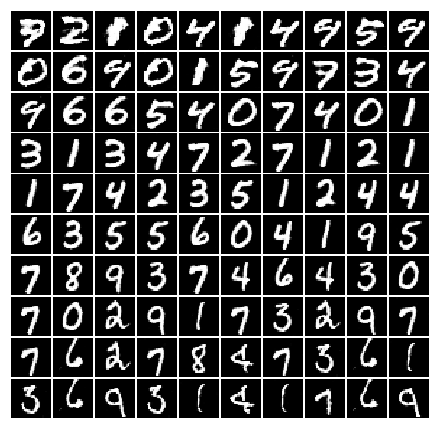

In [51]:
c_ = mnist.test.labels[:100]
samples = sess.run(G_sample, {z: v, c: c_, training: False})
fig = plot(samples, shape=(10, 10))
plt.show()

In [52]:
c_ = mnist.test.labels[0]

In [56]:
c_ = np.tile(c_, 100).reshape(100, 10)

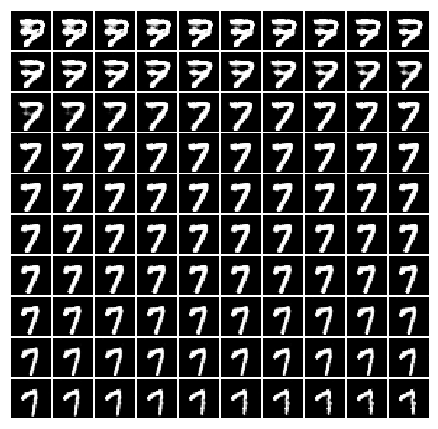

In [57]:
samples = sess.run(G_sample, {z: v, c: c_, training: False})
fig = plot(samples, shape=(10, 10))
plt.show()